## Package Installation
This cell installs the required Python packages: seaborn for visualization, emoji for emoji handling, and datasets for data management.

In [36]:
!pip install seaborn emoji datasets

In [37]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
import tensorflow as tf
import tf_keras
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import Dataset, DatasetDict, concatenate_datasets

In [38]:
np.object = object

In [39]:
model_name = "google-bert/bert-base-multilingual-cased" #cased signifie que le modele distingue les majuscules et les minuscules

##  Data Loading
Mounts Google Drive and loads the multilingual hate speech dataset from the drive.

In [40]:
from google.colab import drive
drive.mount('/content/drive')
pandas_dataset  = pd.read_csv("/content/drive/MyDrive/ProjetNLP/MultiLanguageTrainDataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Exploration
Displays the first few rows of the dataset to understand its structure. The data contains text, label (hate speech or not), and language identifiers.

In [41]:
pandas_dataset.head()

,Unnamed: 0,text,label,language
0,0,لك من جهة ان شاء بضل حرقة بقلبك وبلاطه ع صدرك ...,0.0,1
1,1,انجاز جديد للعهدجبران باسيل,0.0,1
2,2,قلبه كبير وئام وديموقراطي عكس باسيل هههه,0.0,1
3,3,ولك العما بقلبك عمي يا اوطى مخلوق عوج الارض رو...,1.0,1
4,4,يسعد صباحك يا قائد,0.0,1


In [42]:
removed = pandas_dataset.drop(pandas_dataset[pandas_dataset.language==8].index)

## Language Distribution Visualization
Creates a visualization of the language distribution in the dataset

All languages and their counts:
language
2     53146
7     48564
5     27315
6     14508
13    11852
11    11180
4      9866
10     9215
3      8066
9      7106
12     6723
1      4161
Name: count, dtype: int64

Top 3 languages: [2, 7, 5]


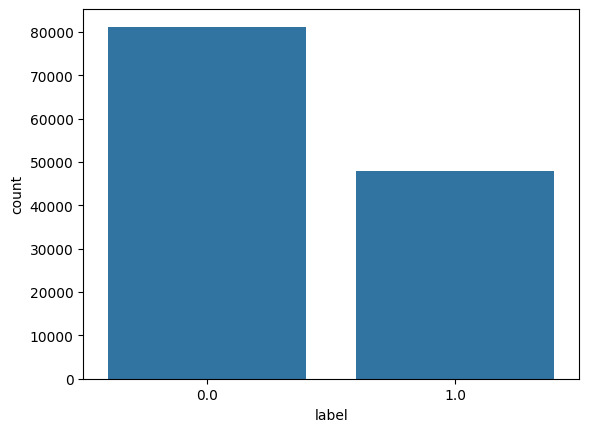

In [43]:
# First, count the occurrences of each language
language_counts = removed['language'].value_counts()

# Display all languages and their counts
print("All languages and their counts:")
print(language_counts)

# Get the top 3 languages
top_3_languages = language_counts.nlargest(3).index.tolist()
print(f"\nTop 3 languages: {top_3_languages}")

# Create a new dataframe with only the top 3 languages
filtered_df = removed[removed['language'].isin(top_3_languages)]

sns.countplot(filtered_df, x="label")
plt.show()

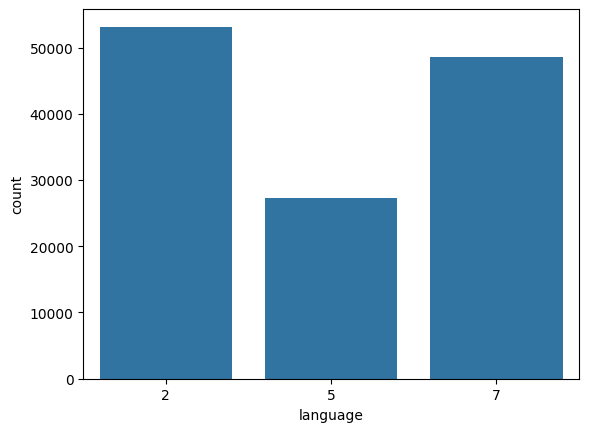

In [44]:
sns.countplot(filtered_df, x="language")
plt.show()

## Text Preprocessing
Cleans the text data by removing mentions (@username), URLs, Twitter picture links, and converting emojis to text using the emoji library. 

In [45]:
#\d\w_ capture les chiffres, lettres et underscores.
#\s? supprime l'espace qui suit la mention (si présent).
#
filtered_df["text_cleaned"] =filtered_df["text"].str.replace(r"@[\d\w_]+\s?", "", regex=True)
filtered_df["text_cleaned"] = filtered_df["text_cleaned"].str.replace(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "", regex=True)
filtered_df["text_cleaned"] = filtered_df["text_cleaned"].str.replace(r"pic.twitter.com/[\w\d]+", "", regex=True)
filtered_df["text_cleaned"] = filtered_df["text_cleaned"].apply(lambda x:emoji.demojize(x))

In [63]:
filtered_df.tail()

,Unnamed: 0,text,label,language,text_cleaned
165621,165621,gşdidlgşldlgkşsdl tmm knk şlajkg nasıl becerdi...,0.0,7,gşdidlgşldlgkşsdl tmm knk şlajkg nasıl becerdi...
165622,165622,İyiymiş 😂😂çok aydın bir nesil geliyor bak bu d...,0.0,7,İyiymiş :face_with_tears_of_joy::face_with_tea...
165623,165623,@USER Fitili de oral olarak alan var 🤣🤣🤣 ah bi...,0.0,7,Fitili de oral olarak alan var :rolling_on_the...
165624,165624,Lana ile harika bir düet yapabilecekken neden ...,1.0,7,Lana ile harika bir düet yapabilecekken neden ...
165625,165625,İngiltere’nin en ünlü lisesi Eton College.. ...,1.0,7,İngiltere’nin en ünlü lisesi Eton College.. ...


In [47]:
ds = None
for language in filtered_df["language"].unique():
    train_val_test = Dataset.from_pandas(filtered_df[filtered_df.language==language]).train_test_split(train_size=0.7)
    val_test = train_val_test["test"].train_test_split(train_size=2/3)
    if ds is None:
        ds = DatasetDict({
            "train": train_val_test["train"],
            "valid": val_test["train"],
            "test": val_test["test"]
        })
    else:
        ds["train"] = concatenate_datasets([ds["train"], train_val_test["train"]])
        ds["valid"] = concatenate_datasets([ds["valid"], val_test["train"]])
        ds["test"] = concatenate_datasets([ds["test"], val_test["test"]])



In [48]:
ds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'language', 'text_cleaned', '__index_level_0__'],
        num_rows: 90316
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'language', 'text_cleaned', '__index_level_0__'],
        num_rows: 25805
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'language', 'text_cleaned', '__index_level_0__'],
        num_rows: 12904
    })
})

In [49]:
ds_rem = ds.remove_columns(["text", "language", "__index_level_0__"])
ds_rem

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'text_cleaned'],
        num_rows: 90316
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'label', 'text_cleaned'],
        num_rows: 25805
    })
    test: Dataset({
        features: ['Unnamed: 0', 'label', 'text_cleaned'],
        num_rows: 12904
    })
})

## Tokenization 
- Initializes the tokenizer from the pre-trained model selected earlier.
- Prints tokenizer information including vocabulary size, maximum sequence length, and input names to understand its configuration.
- Tokenizes the text data for all splits (train, validation, test) using the BERT tokenizer with specified parameters like padding and truncation.




In [50]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [51]:
print(f"Vocab size is {tokenizer.vocab_size}")
print(f"Max length is {tokenizer.model_max_length}")
print(f"Model input names are {tokenizer.model_input_names}")

Vocab size is 119547
Max length is 512
Model input names are ['input_ids', 'token_type_ids', 'attention_mask']


In [52]:
tok_dataset = ds_rem.map(
    lambda ds_t: tokenizer(
        ds_t["text_cleaned"],
        padding="max_length",
        max_length=128,  # Use a smaller value based on your actual text lengths
        truncation=True
    ),
    batched=True
)

Map:   0%|          | 0/90316 [00:00<?, ? examples/s]

Map:   0%|          | 0/25805 [00:00<?, ? examples/s]

Map:   0%|          | 0/12904 [00:00<?, ? examples/s]

In [53]:
tok_dataset = tok_dataset.remove_columns(["text_cleaned"])

In [54]:
train_set = tok_dataset["train"].with_format("tf")
valid_set = tok_dataset["valid"].with_format("tf")
test_set = tok_dataset["test"].with_format("tf")

In [55]:
train_features = {x:train_set[x] for x in tokenizer.model_input_names}
train_set_final = tf.data.Dataset.from_tensor_slices((train_features, train_set["label"])).shuffle(len(train_set)).batch(32)
test_features = {x:test_set[x] for x in tokenizer.model_input_names}
test_set_final = tf.data.Dataset.from_tensor_slices((test_features, test_set["label"])).shuffle(len(test_set)).batch(32)
valid_features = {x:valid_set[x] for x in tokenizer.model_input_names}
valid_set_final = tf.data.Dataset.from_tensor_slices((valid_features, valid_set["label"])).shuffle(len(valid_set)).batch(32)

In [56]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices:", strategy.num_replicas_in_sync)

Number of devices: 1


##  Distribution Strategy
Sets up TensorFlow's MirroredStrategy for potential multi-GPU training, though only one device is detected.

In [57]:


with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.compile(
        optimizer = "adam",
        loss = "binary_crossentropy",
        metrics = ["acc"]
    )


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
model_checkpoint_callback = tf_keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/checkpoint_model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [59]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_113 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 177854978 (678.46 MB)
Trainable params: 177854978 (678.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training
Trains the model on the training data, validates on validation data for 3 epochs.

In [ ]:
history = model.fit(train_set_final, validation_data=valid_set_final, epochs=3)
# Sauvegarde du modèle au format TensorFlow SavedModel
model.save("/content/drive/MyDrive/ProjetNLP/hate_speech_mbert")
model.save_weights("/content/drive/MyDrive/ProjetNLP/hate_speech_mbert_weights.h5")


Epoch 1/3
2823/2823 [==============================] - 373s 119ms/step - loss: 7.6519 - acc: 0.6297 - val_loss: 7.6575 - val_acc: 0.6259
Epoch 2/3
2823/2823 [==============================] - 310s 110ms/step - loss: 7.6571 - acc: 0.6299 - val_loss: 7.6575 - val_acc: 0.6259
Epoch 3/3
2823/2823 [==============================] - 309s 109ms/step - loss: 7.6571 - acc: 0.6299 - val_loss: 7.6575 - val_acc: 0.6259


##  Visualization of Training Results
Creates and saves plots of the training and validation loss and accuracy.

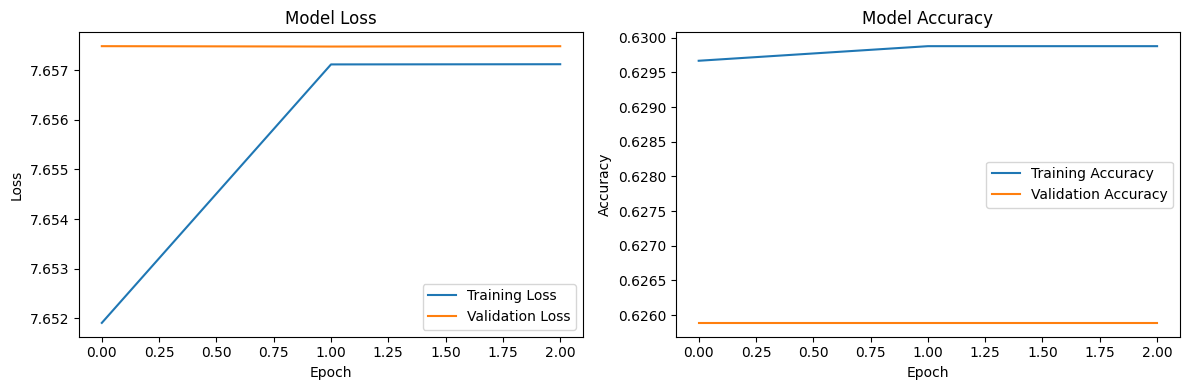

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save the figure
    plt.savefig("/content/drive/MyDrive/ProjetNLP/training_history.png")

# Call the function after training
plot_training_history(history)

## Confusion Matrix 

In [ ]:
def plot_confusion_matrix(model, test_dataset):
    # Make predictions
    y_pred = []
    y_true = []

    # Collect predictions and true labels
    for batch in test_dataset:
        features, labels = batch
        predictions = model.predict(features)
        predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

        y_pred.extend(predicted_classes)
        y_true.extend(labels.numpy())

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Hate', 'Hate'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/ProjetNLP/confusion_matrix.png")
    plt.show()

    # Print classification report
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=['Not Hate', 'Hate']))

# Call the function after training
print("Generating confusion matrix...")
plot_confusion_matrix(model, test_set_final)